# Rotini

**Background**

We prepare a Hall strip and then watch the free evolution of a quasi-1D interacting BEC under a gauge field with no external scalar potential in the rotating frame.

In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy
from tqdm.notebook import tqdm
from scipy.ndimage import rotate as rotate_image
from scipy.optimize import curve_fit
import time
import h5py
import pandas as pd
from condensate import Wavefunction, Environment, hbar
%matplotlib inline

## Prepare groundstate

In [29]:
omega   = 2*np.pi*10
epsilon = 0.6
dt = 1e-5
fov = 300e-6

e = Environment(DIM=512, fov=fov, N=1e6)
e.harmonic_potential(omega=omega, epsilon=epsilon)


            Running condensate on 512x512 grid with:
            atom number: 1e+06 
            mass:        3.80e-26
        


In [30]:
groundstate = Wavefunction(e)
groundstate.initialize_Psi(width=100)
groundstate.relax(vmax=2e8, dt=dt, steps=4000)

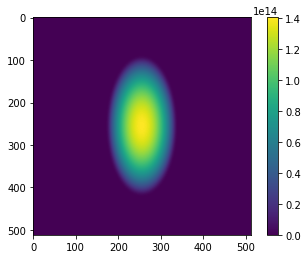

In [31]:
groundstate.show_density()

In [32]:
x = np.linspace(-5,5,512)
xx, yy = np.meshgrid(x, x)
phase = xx * yy

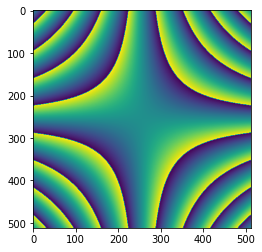

In [33]:
plt.imshow(np.angle(np.exp(1j * phase)))

In [53]:
start = deepcopy(groundstate)
start.Psi*=np.exp(20j * phase)
start.env.harmonic_potential(omega=omega, epsilon=0)

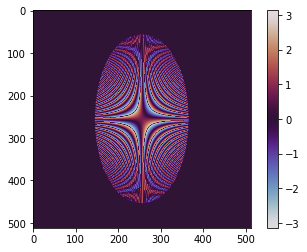

In [54]:
start.show_phase()

In [55]:
start.evolve(steps=1e4, dt=1e-5, cooling=0)

## Spin up

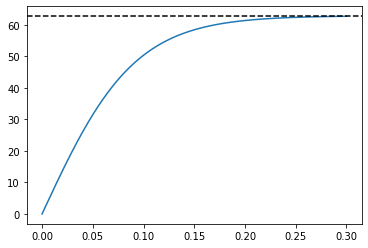

In [94]:
whirrMax = omega
steps = 30000
whirrtime = 30000
times = np.arange(steps)
Omega = [np.min([whirrMax, omega * 1.001 * np.tanh(3.3 * t / whirrtime)]) for t in times]

plt.plot(dt*times, Omega)
plt.axhline(Omega[-1],ls='--',c='k')
plt.show()

In [95]:
hallstrip = deepcopy(groundstate)

In [96]:
hallenv = hallstrip.env
hallenv.rotating_frame(omegaR=Omega)
hallenv.absorbing_boundaries(strength=1, radius=e.fov/2)

hallstrip.evolve(dt=dt, steps=steps, cooling=0)

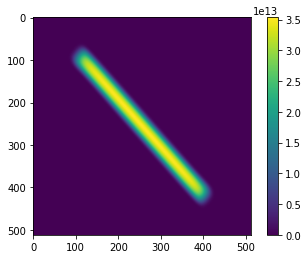

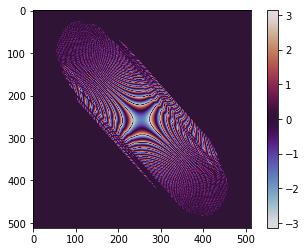

In [97]:
hallstrip.show_density()
hallstrip.show_phase()

In [98]:
startstrip = deepcopy(hallstrip)

In [73]:
steps=20000
startstrip.env.rotating_frame(omegaR=omega*np.ones(steps))
startstrip.evolve(steps=steps, cooling=0.0, dt=2e-5)

In [74]:
rotini = deepcopy(startstrip)

In [75]:
rotini.env.harmonic_potential(omega=omega, epsilon=0)
rotini.env.rotating_frame(omegaR=[omega])

In [76]:
DIM = 512
noise = (0.j)*np.zeros((DIM,DIM))
for i in range(DIM):
    for j in range(DIM):
        noise[i,j]= np.exp(0.2 * 1.j * 2*np.pi * (0.5-np.random.rand()))

In [77]:
rotini.Psi *= noise

In [78]:
rotini.evolve(steps=0, cooling=0.0)

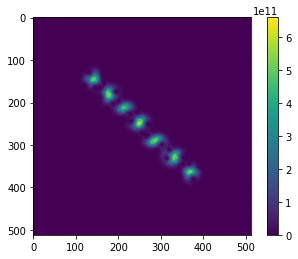

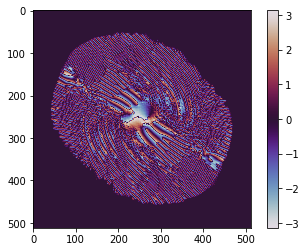

In [79]:
rotini.show_density()
rotini.show_phase()

In [ ]:
def compute_rotini(stripPsi, stripsteps, rotinisteps=250000, show=True, usenoise=True, frames=50, datafile='data/rotini.hdf5'):
    steps = frames*(rotinisteps//frames)
    runtime = steps//frames
    times = np.arange(steps)
    Omega = omega* np.ones(runtime)
    dt = 1e-5
    x = stripPsi.copy() * noise if usenoise else stripPsi.copy()
    vmax = np.max(np.abs(x))**2
    out = []
    density = np.fliplr(np.abs(x.copy())**2)
    density *= density>1
    out.append(density)
    
    for i in tqdm(range(frames), leave=False):
        gpcore.Setup(DIM, fov, g, dt, False, 0.00)
        gpcore.SetHarmonicPotential(omega,0) #omega, epsilon
        gpcore.RotatingFrame(Omega)
        gpcore.Evolve(x, runtime , 50, show, vmax)
        
        density = np.fliplr(np.abs(x.copy())**2)
        density *= density>1
        out.append(density)
        
    with h5py.File(datafile, 'a') as f:
        dsname = f"rotini1D_{stripsteps}" if usenoise else f"rotini1D_{stripsteps}_nonoise"
        dset = f.create_dataset(dsname, data=np.array(out))
        dset.attrs['stripsteps'] = stripsteps
        dset.attrs['time'] = dt*runtime * np.arange(frames)
        dset.attrs['dt'] = dt

In [23]:
def geometric_squeezing(stripPsi, steps=60000, frames=300, datafile='data/geometricsqueezing.hdf5'):
    steps = frames*(steps//frames)
    runtime = steps//frames
    times = np.arange(steps)
    Omega = omega* np.ones(runtime)
    dt = 1e-5
    psi = copy(stripPsi)
    psi.env.rotating_frame(omegaR=Omega)
    out = []
    density = psi.density
    density *= density>1
    out.append(density)
    
    for i in tqdm(range(frames), leave=False):
        psi.evolve(dt=dt, steps=runtime, cooling=0.0)
        density = psi.density
        density *= density>1
        out.append(density)
        
    with h5py.File(datafile, 'a') as f:
        dsname = f"geosqueeze"
        dset = f.create_dataset(dsname, data=np.array(out))
        dset.attrs['time'] = dt*runtime * np.arange(frames)
        dset.attrs['dt'] = dt

## Process Data

In [25]:
# Set some processing parameters
viewx = 350
viewy = 350
fov = 300e-6
dx = fov/512
mass = 3.8e-26
lb = np.sqrt(hbar / (2*mass *omega))
x  = dx * (np.arange(viewx) - viewx//2)
y  = dx * (np.arange(viewy) - viewy//2)
dt = 1e-5
times = np.arange(51)*dt*5e3


def gauss(x,x0,a,s): return a*np.exp(- (x-x0) **2 / (2*s**2))

def satexp(t, tau,a): return (3.31+a*np.exp(-t/tau))

def rotate_crop(array, viewx=200, viewy=350, angle=0):
    """ Rotate and crop a 2d array """
    s = np.shape(array)
    rotated = rotate_image(array, angle, reshape=False)
    cropped = rotated[(s[0]-viewy)//2 : (s[0]+viewy)//2 , (s[1]-viewx)//2 : (s[1]+viewx)//2 ]
    return cropped

def find_angle(ncrop):
    xsize = len(ncrop)
    xx = np.linspace(-10, 10, xsize)
    yy = np.linspace(-10, 10, xsize)
    xx, yy = np.meshgrid(xx, yy)

    # Calculate the moment of inertia tensor
    Ixx = np.sum(ncrop*yy*yy)
    Iyy = np.sum(ncrop*xx*xx)
    Ixy = np.sum(ncrop*xx*yy)
    Iyx = Ixy
    I =np.array( [[Ixx, Ixy], [Iyx, Iyy]])
    evals, evecs = np.linalg.eig(I)
    iangle = (180*np.arctan(evecs[np.argmin(evals)][1]/evecs[np.argmin(evals)][0])/np.pi)
    return iangle

    
def process_r1d(dset):
    """ Process a dataset corresponding to a single squeeze time """
    clouds = np.array([rotate_crop(a, viewx, viewy, 42) for a in dset[()]])
    times = np.array(dset.attrs['time'])
    xprofile  =  np.sum(rotate_crop(clouds[0],viewy=150), axis=0)
    xprofilemax = np.max(xprofile)
    gaussfit,_ = curve_fit(gauss, x, xprofile, [0, xprofilemax, 6e-6])
    newresults = pd.DataFrame([[clouds, times, xprofile, gaussfit]],
                              columns=columns)
    return newresults




In [46]:
columns = ['cloud', 'time', 'xprofile', 'gaussfit']
gs = pd.DataFrame(columns=columns)

with h5py.File('data/geometricsqueezing.hdf5', 'r') as f:
    for name in tqdm(f):
        dset=f[name]
        alltimes =  np.array(dset.attrs['time'])
        for i in tqdm(range(len(dset)-1), leave=False):
            cloud = rotate_crop(np.fliplr(dset[i]), viewx, viewy, 42.2)
            xprofile  =  np.sum(rotate_crop(cloud, viewx=350, viewy=150), axis=0)
            xprofilemax = np.max(xprofile)
            gaussfit,_ = curve_fit(gauss, x, xprofile, [0, xprofilemax, 6e-6])
            newresults = pd.DataFrame([[cloud, alltimes[i], xprofile, gaussfit]], columns=columns)
            gs = gs.append(newresults)
            
        
        
    

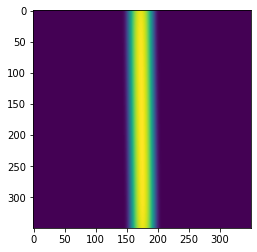

In [24]:
plt.imshow(gs.iloc[0].cloud)

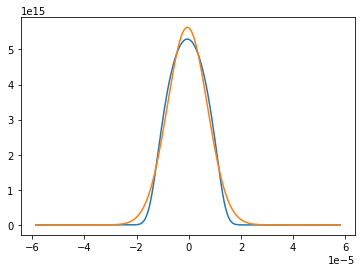

In [11]:
plt.plot(x,gs.iloc[0].xprofile)
plt.plot(x,gauss(x,*gs.iloc[0].gaussfit))

In [12]:
gs.head()

,cloud,time,xprofile,gaussfit
0,"[[2.7126095591907048e-11, -4.8243962259616635e...",0.000,"[9.32053512940961e-09, -4.1944736536293555e-08...","[-5.377215836858165e-07, 5633362403424438.0, 7..."
0,"[[-2.167784531647882e-12, 1.4503769748717715e-...",0.002,"[-2.5111884874582545e-10, -6.488398696351045e-...","[-5.768934624889789e-07, 5634538193729892.0, 7..."
0,"[[2.8597784904207056e-13, -2.3205898553101973e...",0.004,"[4.573862723064566e-12, 1.4403617961391765e-11...","[-5.858469240930829e-07, 5602642182199426.0, 7..."
0,"[[-4.608010310441162e-15, 3.2517888864800703e-...",0.006,"[-1.1023522712951248e-13, -2.1303718276767428e...","[-5.608554571660093e-07, 5525174654175018.0, 7..."
0,"[[1.8211601881375992e-17, 4.440056450750012e-1...",0.008,"[2.9156380635562312e-15, -1.0370908202275614e-...","[-5.038568694027151e-07, 5397949244664887.0, 7..."


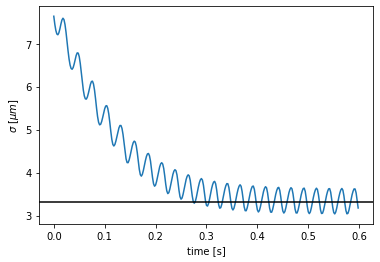

In [50]:
widths = np.array([abs(r[4][2]) for r in gs.itertuples()])
plt.plot(gs['time'], 1e6*widths)
plt.axhline(1e6*lb/np.sqrt(2),c='k')
plt.xlabel('time [s]')
plt.ylabel(r'$\sigma$ [$\mu m$]')
plt.savefig('figures/rotini1d/widths.png')


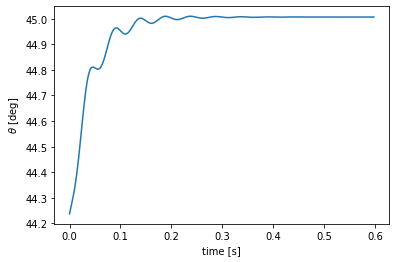

In [60]:
angles = []
for i,r in gs.iterrows():
    angles.append(find_angle(r.cloud))
    
plt.plot(gs['time'], -44.97+np.array(angles))
# plt.axhline(90,c='k')
plt.xlabel('time [s]')
plt.ylabel(r'$\theta$ [deg]')
plt.savefig('figures/rotini1d/angles.png')

# Reproducing lab parameters


            Running condensate on 512x512 grid with:
            atom number: 8e+05 
            mass:        3.80e-26
        


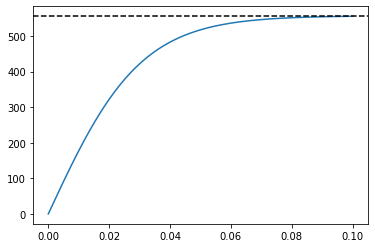

In [2]:
omega   = 2*np.pi*88.6
epsilon = 0.2
dt = 1e-6

e = Environment(DIM=512, fov=120e-6, N=8e5)
e.harmonic_potential(omega=omega, epsilon=epsilon)

groundstate = Wavefunction(e)
groundstate.initialize_Psi(width=100)
groundstate.relax(vmax=1e9, dt=2*dt, steps=4000)
groundstate.evolve(dt=dt, cooling=0.01, steps=4000)

whirrMax = omega
steps = 100000
whirrtime = 100000
times = np.arange(steps)
Omega = [np.min([whirrMax, omega * 1.001 * np.tanh(3.3 * t / whirrtime)]) for t in times]
plt.plot(dt*times, Omega)
plt.axhline(Omega[-1],ls='--',c='k')
plt.show()


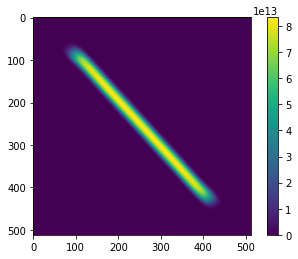

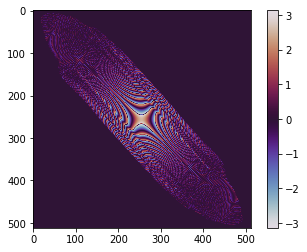

In [3]:
# Run the sim - takes longer than the 10Hz sim above
hallstrip = deepcopy(groundstate)
hallenv = hallstrip.env
hallenv.rotating_frame(omegaR=Omega)
hallenv.absorbing_boundaries(strength=1, radius=e.fov/2)

hallstrip.evolve(dt=dt, steps=steps, cooling=0)
hallstrip.show_density()
hallstrip.show_phase()

In [4]:
finalstrip = deepcopy(hallstrip)

## Crop and find the angle to the diagonal after the ramp

In [10]:
width = 512//2
plotrange=140
ncrop = finalstrip.density[(width-plotrange):(width+plotrange),(width-plotrange):(width+plotrange)]

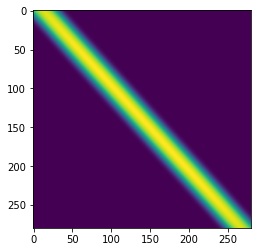

In [13]:
plt.imshow(ncrop)

In [20]:
xsize = len(ncrop)
xx = np.linspace(-10, 10, xsize)
yy = np.linspace(-10, 10, xsize)
xx, yy = np.meshgrid(xx, yy)

# Calculate the moment of inertia tensor
Ixx = np.sum(ncrop*yy*yy)
Iyy = np.sum(ncrop*xx*xx)
Ixy = np.sum(ncrop*xx*yy)
Iyx = Ixy
I =np.array( [[Ixx, Ixy], [Iyx, Iyy]])
evals, evecs = np.linalg.eig(I)
iangle = (180*np.arctan(evecs[np.argmin(evals)][1]/evecs[np.argmin(evals)][0])/np.pi)


In [21]:
print(f"angle from diagonal equipotential: {(iangle-45):.2f} degrees")

angle from diagonal equipotential: 2.47 degrees
